In [55]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import random as rd
from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Embedding, LSTM 
from keras.datasets import imdb 

In [81]:
'''
La démarche principale ici a été de reprendre le code déjà précédemment écrit, et de l'adapter au LSTM. Ainsi, il reste des fonctions
de code qui ne servent à rien ici, seule la dernière cellule nous intéresse dans notre cas. Fonctionne!
'''

"\nLa démarche principale ici a été de reprendre le code déjà précédemment écrit, et de l'adapter au LSTM. Ainsi, il reste des fonctions\nde code qui ne servent à rien ici, seule la dernière cellule nous intéresse dans notre cas.\n"

In [56]:
# Generate noisy cos
def generate_x(duration, nb_val):

    """ Generate cos signal with real and imaginary part.\n
    Parameters : \n
    \t duration : time length of signal,\n
    \t nb_val : number of samples in duration """

    x_axis = np.linspace(0, duration-1, nb_val)
    x_data = np.cos(x_axis) + 0.1*np.rd.normal(size = nb_val)*(1+.5j) + np.cos(x_axis+np.pi/2)*.5j
    return x_axis, x_data

# Generate low-passed random signal
def generate_randx(duration, nb_val):

    """ Generate low-passed random signal with real and imaginary part.\n
    Parameters : \n
    \t duration : time length of signal,\n
    \t nb_val : number of samples in duration """

    x_axis = np.linspace(0, duration-1, nb_val)
    x_data = np.zeros(x_axis.size, dtype = np.complex128)
    for i in range(x_axis.size):
        x_data[i] = rd.randint(0,100) + rd.randint(0,100)*1j
    x_data = np.convolve(x_data, np.array([1,1,1,1,1,1,1,1,1,1,1,1,1])/13, mode='same')
    return x_axis, x_data

# Returns a list of arrays size 2*mem_depth containing real and imaginary parts of last samples (memory)
def memory(x, mem_depth):

    """ Returns list of arrays of size 2*mem_depth containing real and imaginary parts of last samples (memory).\n
    Parameters : \n
    \t x : input signal,\n
    \t mem_depth : number of last samples taken into account in output at instant t """

    final = []
    for i in range(mem_depth, x.size+1):
        sample = x[i-mem_depth:i]
        sample = np.flip(sample,0)
        x_r = np.zeros(mem_depth) # real parts of sample
        x_i = np.zeros(mem_depth) # imaginary parts of sample
        for k in range(sample.size): # fill in real and imaginary samples
            x_r[k] = sample[k].real
            x_i[k] = sample[k].imag
        final.append(np.concatenate((x_r, x_i)))
    return final

# Generate output signal
def output(x_data, h1, h2):

    """ Returns output after non linear filter. \n
    Parameters :\n
    \t x_data : input,\n
    \t h1 : filter applied to x_data,\n
    \t h2 : filter applied to x_data**2"""
    
    x_data_squared = x_data**2
    output = np.convolve(x_data, h1) + np.convolve(x_data_squared, h2)
    output = output[h1.size-1:-h1.size+1] # remove unwanted values issues from convolution
    y_data = np.zeros((output.size, 2))
    #print(y_data)
    for i in range(output.size):
        y_data[i][0] = output[i].real
        y_data[i][1] = output[i].imag
    return y_data

In [57]:
# Global parameters

activations = np.array(["relu", "tanh", "sigmoid"])

In [58]:
def generate_data(show=False):

    """ Generate random data to test models. Returns x_data, corresponding y_data, mem_depth. \n
    Parameters : \n
    \t show : whether input and output signal are displayeds """

    duration = 10 # 10 for cos signal (time period)
    nb_val = 200 # duration*100 for cos signal (number of values)

    # Filter of size mem_depth
    h1 = np.array([1, 2, 3, 4]) # filter on x
    h2 = np.array([4, 3, 2, 1]) # filter on x^2
    mem_depth = h1.size

    # Create input
    x_axis, x_data = generate_randx(duration, nb_val) # Random signal
    data = memory(x_data, 4)
    data = np.array(data)
    # Normalize input
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Create output from filter
    y_data = output(x_data, h1, h2)
    # Normalize output
    scaler = StandardScaler()
    y_data = scaler.fit_transform(y_data)

    # Display
    if show :
        plt.plot(x_axis[h1.size-1:], data[:,0])
        plt.title("Normalized input signal (real)")
        plt.show()
        plt.plot(x_axis[h1.size-1:], y_data[:,0], color = "red")
        plt.title("Normalized output signal (real)")
        plt.xlabel("Time")
        plt.show()

    return x_axis, data, y_data, mem_depth

In [59]:
# Create model 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(mem_depth*2, activation = "linear", input_shape=[h1.size*2])) # input is real and imaginary values of x
model.add(tf.keras.layers.Dense(5, activation = "tanh"))
#model.add(tf.keras.layers.Dense(5, activation = "tanh"))
model.add(tf.keras.layers.Dense(2, activation = "linear")) # output is real and imaginary values of y

model.compile(
    loss = "mse",
    optimizer = "adam"
)

# Display the model
model.summary()

NameError: name 'h1' is not defined

In [60]:
history = model.fit(data, y_data, epochs=500, verbose=1, validation_split = 0.2)

NameError: name 'data' is not defined

In [61]:
def display_loss(history):

    """ Display the train_loss and val_loss curves. """

    # Display loss
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    plt.plot(train_loss, label = "train loss")
    plt.plot(val_loss, label = "val loss")
    plt.legend()
    plt.title("Loss evolution")
    plt.show()


def display_prediction(model, x_axis, x_data, y_data, mem_depth):

    """ Predict the output for input x_data with model and display."""

    # Compute the output
    y_predicted = model.predict(x_data)

    # Display the result
    plt.scatter(x_axis[mem_depth-1::1], y_data[::1, 0], s=3, label = "Measures")
    plt.plot(x_axis[mem_depth-1:], y_predicted[::1, 0], 'r', linewidth=1, label = "Prediction")
    plt.title("Real part of output")
    plt.legend()
    plt.grid()
    plt.show()

    plt.scatter(x_axis[mem_depth-1::1], y_data[::1, 1], s=3, label = "Measures")
    plt.plot(x_axis[mem_depth-1:], y_predicted[::1, 1], 'r', linewidth=1, label = "Prediction")
    plt.title("Imaginary part of output")
    plt.legend()
    plt.grid()
    plt.show()

In [62]:
# Test set

x_axis, test_data = generate_randx(duration, nb_val)
test_y = output(test_data, h1, h2)

test_data = memory(test_data, h1.size)
test_data = np.array(test_data)

# Normalize input
scaler = StandardScaler()
test_data = scaler.fit_transform(test_data)

# Normalize output
scaler = StandardScaler()
test_y = scaler.fit_transform(test_y)

# Compute the output
test_y_predicted = model.predict(test_data)

# Display the result
plt.scatter(x_axis[mem_depth-1::1], test_y[::1, 0], s=3, label = "Measures")
plt.plot(x_axis[mem_depth-1:], test_y_predicted[::1, 0], 'r', linewidth=1, label = "Prediction")
plt.title("Real part of output")
plt.legend()
plt.grid()
plt.show()

plt.scatter(x_axis[mem_depth-1::1], test_y[::1, 1], s=3, label = "Measures")
plt.plot(x_axis[mem_depth-1:], test_y_predicted[::1, 1], 'r', linewidth=1, label = "Prediction")
plt.title("Imaginary part of output")
plt.legend()
plt.grid()
plt.show()

NameError: name 'duration' is not defined

In [64]:
# TEST MODELS

def create_model(parameters, mem_depth):

    """ Create a model from the info indicated in input. \n
    Parameters :\n
    \t parameters : 2D array with #lines = #hiddenlayers and line = [#neurons, #activationfunction]
    \t mem_depth : number of latest values taken into account in output computation """

    list_activ = []
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(mem_depth*2, activation = "linear", input_shape=[mem_depth*2])) # input is re and im values of last xs
    for layer in parameters :
        act = activations[layer[1]]
        model.add(tf.keras.layers.Dense(layer[0], activation = f"{act}"))
        list_activ.append(act)
    model.add(tf.keras.layers.Dense(2, activation = "linear")) # output is real and imaginary values of y

    model.compile(
        loss = "mse",
        optimizer = "adam"
    )

    return model, list_activ

def create_random_param(max_lines=4, max_neurons=15):

    """ Create a 2D array of parameters with #lines = #hiddenlayers and line = [#neurons, activationfunction]\n
    \t #lines is between 1 and max_lines,
    \t #neurons is between 1 and max_neurons,
    \t activationfunction is 'relu', 'sigmoid' or 'tanh' """

    nb_lines = rd.randint(1,max_lines)
    parameters = np.zeros((nb_lines, 2), dtype="int32")
    for l in range(nb_lines):
        parameters[l,0], parameters[l,1] = rd.randint(1,max_neurons), rd.randint(0,2)
    return parameters

In [ ]:
# p = create_random_param()
# print(p)
# m = create_model(p, 4)
# m.summary()

In [65]:
def execute_model(model, x_data, y_data, ep=400, val_split=0.2):

    """ Executes model.fit on parameters, returns loss. \n
    Parameters :\n
    \t model : model executed,
    \t x_data : input data (array)
    \t y_data : output data to be approximated
    \t ep : number of iterations of learning (epochs)
    \t val_split : proportion of data to be used as validation """

    history = model.fit(x_data, y_data, epochs = ep, verbose = 0, validation_split = val_split)
    return history.history["loss"], history.history["val_loss"]

In [66]:
def display_result(x_data, y_data, show=False, mem_depth=4, ep=400):

    """ Shows the paramaters of a model and the train and val loss as estimation of its accuracy, returns the last value of val_loss.\n
    Parameters :\n
    \t mem_depth : number of latest values taken into account in output computation
    \t show : whether result is shown """

    model, list_activ = create_model(create_random_param(), mem_depth)
    train_loss, val_loss = execute_model(model, x_data, y_data, ep)
    if show:
        print(f"Liste de fonctions d'activations : {list_activ}")
        model.summary()
        plt.plot(train_loss, label = "train loss")
        plt.plot(val_loss, label = "val loss")
        plt.legend()
        plt.title("Loss evolution")
        plt.show()
    return model, list_activ, val_loss[-1]
    

#val_loss = display_result(show=False)
#print(val_loss)

Data created successfully !
Model number 1/10 calculating...
Model number 2/10 calculating...
Model number 3/10 calculating...
Model number 4/10 calculating...
Model number 5/10 calculating...
Model number 6/10 calculating...
Model number 7/10 calculating...
Model number 8/10 calculating...
Model number 9/10 calculating...
Model number 10/10 calculating...

-----------------

————————————————————————————————————————
-----------------

The best model is model number 7
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 18        
Total params: 162
Trainable params: 162
Non-

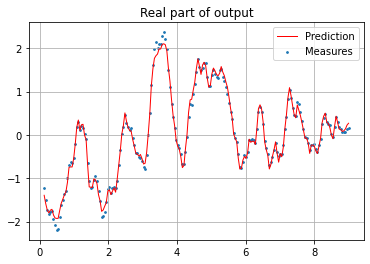

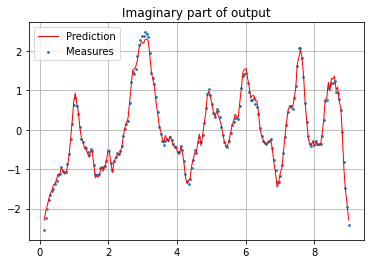

In [67]:
def test_models(nb_models=5, ep=400, show_all = False):

    """ Generates data once and tests the performance nb_models models. \n
    Parameters :\n
    \t nb_models : number of random models tested """

    x_axis, x_data, y_data, mem_depth = generate_data() # create data to work on
    print("Data created successfully !")
    models = []
    list_activs = []
    val_losses = []

    # Use models
    for i in range(nb_models):
        print(f"Model number {i+1}/{nb_models} calculating...")
        model, list_activ, val_loss = display_result(x_data, y_data, mem_depth = mem_depth, ep=ep)
        models.append(model)
        list_activs.append(list_activ)
        val_losses.append(val_loss)
    
    # Show all models tested
    if show_all :
        for i in range(len(models)):
            print("\n--------------------------\n")
            models[i].summary()
            print(f"Activation functions for each hidden layer {list_activs[i]}")
            print(f"val loss associated : {val_losses[i]}")

    # Show best model
    best = np.argmin(val_losses)
    print("\n-----------------\n")
    for i in range(40) :
        print("—",end='')
    print("\n-----------------\n")
    print(f"The best model is model number {best+1}")
    models[best].summary()
    print(f"Activation functions for each hidden layer {list_activs[best]}")
    print(f"Val loss : {val_losses[best]}")
    display_prediction(models[best], x_axis, x_data, y_data, mem_depth)

    return models, list_activs, val_losses, best

models, list_activs, val_losses, best = test_models(nb_models = 10, ep=300)

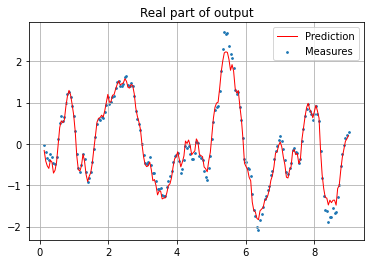

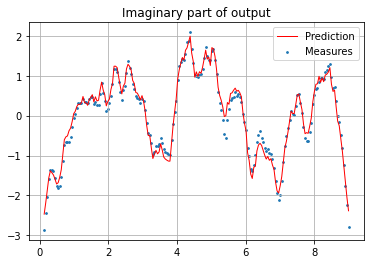

shape x_axis  (200,)
shape test_y  (197, 2)
shape test_y_predicted  (197, 2)


In [68]:
model = models[best]


x_axis, testx_data, test_y, mem_depth = generate_data()

# Compute the output
test_y_predicted = model.predict(testx_data)

# Display the result
plt.scatter(x_axis[mem_depth-1::1], test_y[::1, 0], s=3, label = "Measures")
plt.plot(x_axis[mem_depth-1:], test_y_predicted[::1, 0], 'r', linewidth=1, label = "Prediction")
plt.title("Real part of output")
plt.legend()
plt.grid()
plt.show()

plt.scatter(x_axis[mem_depth-1::1], test_y[::1, 1], s=3, label = "Measures")
plt.plot(x_axis[mem_depth-1:], test_y_predicted[::1, 1], 'r', linewidth=1, label = "Prediction")
plt.title("Imaginary part of output")
plt.legend()
plt.grid()
plt.show()

print('shape x_axis ', x_axis.shape)
print('shape test_y ', test_y.shape)
print('shape test_y_predicted ',test_y_predicted.shape)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 1, 150)            95400     
_________________________________________________________________
dense_25 (Dense)             (None, 1, 64)             9664      
_________________________________________________________________
dense_26 (Dense)             (None, 1, 32)             2080      
_________________________________________________________________
dense_27 (Dense)             (None, 1, 2)              66        
Total params: 107,210
Trainable params: 107,210
Non-trainable params: 0
_________________________________________________________________


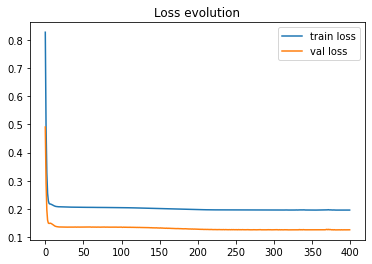

Avant reshape
x_axis est de dim  (200,)
testx_data est de dim  (197, 8)
test_y est de dim  (197, 2)
test_y_predicted est de dim  (197, 1, 2)
Après reshape
x_axis est de dim  (197,)
test_y_predicted est de dim  (197, 2)


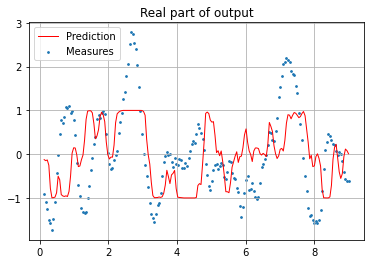

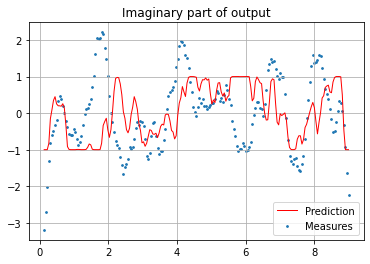

In [80]:
#Génération de données
x_axis, x_data, y_data, mem_depth = generate_data() 

#StackOverflow
x_data = x_data.reshape(-1,1,8)
y_data = y_data.reshape(-1,1,2)

#Génération du modèle
model = Sequential()
#model.add(LSTM(8))
model.add(LSTM(150,input_shape=(1,8),return_sequences=True))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.compile(loss = "mse", optimizer = "adam")
history = model.fit(x_data, y_data, epochs = 400, verbose = 0, validation_split = 0.2)
model.summary()

loss_data = history.history["loss"]
val_loss_data = history.history["val_loss"]
plt.plot(loss_data, label = "train loss")
plt.plot(val_loss_data, label = "val loss")
plt.legend()
plt.title("Loss evolution")
plt.show()


x_axis, testx_data, test_y, mem_depth = generate_data()

#StackOverflow
testx_data_reshaped = x_data.reshape(-1,1,8)
test_y_reshaped = y_data.reshape(-1,1,2)

# Compute the output
test_y_predicted = model.predict(testx_data_reshaped)

print('Avant reshape')
print('x_axis est de dim ',x_axis.shape)
print('testx_data est de dim ',testx_data.shape)
print('test_y est de dim ',test_y.shape)
print('test_y_predicted est de dim ',test_y_predicted.shape)
#test_y_predicted = test_y_predicted.reshape(1,-1)

test_y_predicted = test_y_predicted.reshape((197,2))
#x_axis = x_axis.reshape(1,-1)
x_axis = x_axis[3::]
print('Après reshape')
print('x_axis est de dim ',x_axis.shape)
print('test_y_predicted est de dim ',test_y_predicted.shape)


# Display the result
plt.scatter(x_axis[::1], test_y[::1, 0], s=3, label = "Measures")
plt.plot(x_axis[:], test_y_predicted[::1, 0], 'r', linewidth=1, label = "Prediction")
plt.title("Real part of output")
plt.legend()
plt.grid()
plt.show()

plt.scatter(x_axis[::1], test_y[::1, 1], s=3, label = "Measures")
plt.plot(x_axis[:], test_y_predicted[::1, 1], 'r', linewidth=1, label = "Prediction")
plt.title("Imaginary part of output")
plt.legend()
plt.grid()
plt.show()

